In [1]:
from torchvision.datasets import CIFAR100
from torchvision.models import resnet50,ResNet50_Weights, vgg16,VGG16_Weights, mobilenet_v3_large, MobileNet_V3_Large_Weights
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
fine_tune_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

fine_tune_dataset = CIFAR100(root = 'root', download=True,transform=fine_tune_transform,train=True)
test_dataset =  CIFAR100(root = 'root', download=True,transform=fine_tune_transform,train=False)
test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=False)
fine_tune_loader = DataLoader(fine_tune_dataset,batch_size=32,shuffle=True)

In [2]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_inp = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_inp,100)

vgg_model = vgg16(weights=VGG16_Weights.DEFAULT)
num_inp = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_inp, 100)

mobile_model = mobilenet_v3_large(weights = MobileNet_V3_Large_Weights.DEFAULT)
mobile_model.classifier[3] = nn.Linear(1280, 100)

In [3]:
def test(test_loader,model,device):
    tp = 0
    true = 0
    model.eval()
    with torch.no_grad():
        for x,y in test_loader:
            xd = x.to(device)
            yd = y.to(device)
            out = model(xd)
            y_p = (torch.argmax(out,dim=1) == yd).sum().item()
            true = true+y_p
            tp = tp + len(yd)
    print("accuracy: ", true/tp)

In [4]:
def train(device, model, train_loader, test_loader,epochs, name):
    t_model = model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(t_model.parameters(),lr = 1e-3)
    for i in range(epochs):
        t_model.train()
        e_l = 0
        for x,y in train_loader:
            xd = x.to(device)
            yd = y.to(device)
            out = t_model(xd)
            l = loss(out,yd)
            e_l += l.item()
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
        print("loss: ", e_l/len(train_loader))
        test(test_loader,t_model,device)
        torch.save(t_model.state_dict(),name)

In [5]:
#train("cuda",resnet_model,fine_tune_loader,test_dataloader,6,"resnet_fine_tuned.pth")
#train("cuda",vgg_model,fine_tune_loader,test_dataloader,10,"vgg_fine_tuned.pth")
train("cuda",mobile_model,fine_tune_loader,test_dataloader,10,"mobile_fine_tuned.pth")

loss:  1.678943673617094
accuracy:  0.631
loss:  1.0720329014483128
accuracy:  0.6694
loss:  0.8814020617719042
accuracy:  0.6964
loss:  0.7494155801284489
accuracy:  0.6769
loss:  0.6508004746649484
accuracy:  0.7197
loss:  0.5736938928607291
accuracy:  0.7138


KeyboardInterrupt: 

In [4]:
resnet = resnet50()
st_res = torch.load("resnet_fine_tuned.pth", map_location = "cpu")
resnet.fc = nn.Linear(2048,100)
resnet.load_state_dict(st_res)


mobile = mobilenet_v3_large()
st_mobile = torch.load("mobile_fine_tuned.pth", map_location = "cpu")
mobile.classifier[3] = nn.Linear(1280,100)
mobile.load_state_dict(st_mobile)

features = {}
def save_mobile(module,input,output):
    features["mobile"] = torch.nn.functional.normalize(output.detach(),p = 2, dim = 1)

def save_resnet(module,input,output):
    features["resnet"] = torch.nn.functional.normalize(output.detach().flatten(1),p = 2, dim = 1)

handle_res = resnet.avgpool.register_forward_hook(save_resnet)
handle_mobile = mobile.classifier[2].register_forward_hook(save_mobile)

In [5]:
from overcomplete.sae import TopKSAE

class USAE(nn.Module):
    def __init__(self,dim_res,dim_mobile,z,k):
        super().__init__()
        self.sae_res = TopKSAE(input_shape= dim_res, nb_concepts=z, top_k=k)
        self.sae_mobile = TopKSAE(input_shape = dim_mobile, nb_concepts=z, top_k=k)
    def forward(self,x_res,x_mobile):
        zt_res = self.sae_res.encode(x_res)[1]
        zt_mobile = self.sae_mobile.encode(x_mobile)[1]

        recon_zt_res = self.sae_res.decode(zt_res)
        recon_zt_mobile = self.sae_mobile.decode(zt_mobile)
        recon_zc_res = self.sae_res.decode(zt_mobile)
        recon_zc_mobile = self.sae_mobile.decode(zt_res)

        return {
        "recon_zt_res": recon_zt_res,
        "recon_zt_mobile": recon_zt_mobile,
        "recon_zc_res": recon_zc_res,
        "recon_zc_mobile": recon_zc_mobile
    }


In [ ]:
mobile.eval()
resnet.eval()

dim_res = 2048
dim_mobile = 1280
k = 32
z = 10000
usae = USAE(dim_res,dim_mobile,z,k)
epoch = 14
device = "cuda"
loss = nn.MSELoss()
optimizer = torch.optim.Adam(usae.parameters(),lr = 1e-4)
mobile = mobile.to(device)
resnet = resnet.to(device)
usae = usae.to(device)
train_data = CIFAR100(root = "root",train=True,transform=test_transform)
train_loader = DataLoader(train_data,32,shuffle=True)
for i in range(epoch):
    le = 0
    l1e = 0
    l2e = 0
    l3e = 0
    l4e = 0
    for x,y in train_loader:
        xd = x.to(device)
        yd = y.to(device)
        with torch.no_grad():
            _ = mobile(xd)
            _ = resnet(xd)
        #print(features["resnet"])
        dictionary = usae(features["resnet"],features["mobile"])
        l1 = loss(dictionary["recon_zt_res"],features["resnet"])
        l2 = loss(dictionary["recon_zc_res"],features["resnet"])
        l3 = loss(dictionary["recon_zt_mobile"],features["mobile"])
        l4 = loss(dictionary["recon_zc_mobile"],features["mobile"])
        l = l1 + (1.5)*l2 + l3 + (1.5)*l4
        le += l.item()
        l1e += l1.item()
        l2e += l2.item()
        l3e += l3.item()
        l4e += l4.item()
        l.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(le,", ",l1e,', ',l2e,' ,',l3e,", ",l4e)



2.9287298811832443 ,  0.3881880303961225 ,  0.43464564478199463  , 0.7062835369433742 ,  0.7881932275777217
2.0394113142974675 ,  0.25733475340530276 ,  0.3166932831372833  , 0.4259890364628518 ,  0.5873650650901254
1.8606854298850521 ,  0.22954208112787455 ,  0.2952079892565962  , 0.3763861682091374 ,  0.541296799259726
1.77084279054543 ,  0.21523883356712759 ,  0.28357120396685787  , 0.3538720799260773 ,  0.5175833802786656
1.7154505302896723 ,  0.2063893246013322 ,  0.27600278618047014  , 0.340986477342085 ,  0.5027137008437421
1.677251428423915 ,  0.20035996308433823 ,  0.2705049009528011  , 0.33259100663417485 ,  0.49236207170179114
1.6491192583343945 ,  0.19604665923543507 ,  0.2663170016021468  , 0.32664519773970824 ,  0.4846346011618152
1.6270676591666415 ,  0.1927776763404836 ,  0.26292743648809846  , 0.3221053892339114 ,  0.47852896407130174
1.6092778781894594 ,  0.1902457642936497 ,  0.2601911523961462  , 0.3186282524402486 ,  0.4734114221355412
1.594252233800944 ,  0.188231

KeyboardInterrupt: 

7739.0986328125


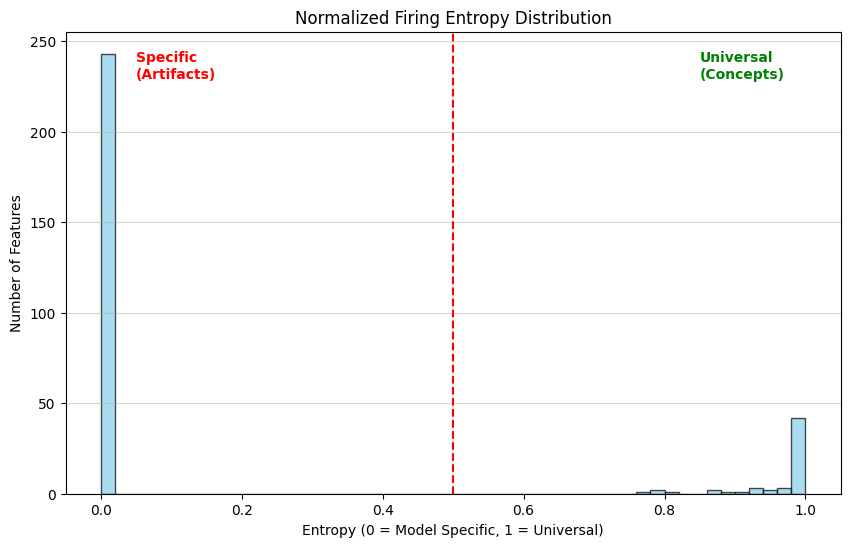

In [31]:
import numpy as np
import matplotlib.pyplot as plt
global_sum_res = torch.zeros(z, device=device)
global_sum_mob = torch.zeros(z, device=device)

for x,_ in test_dataloader:
    xd = x.to(device)
    with torch.no_grad():
        _ = mobile(xd)
        _ = resnet(xd)

        batch_res = usae.sae_res.encode(features["resnet"])[1]
        batch_mobile = usae.sae_mobile.encode(features["mobile"])[1]
        batch_res = batch_res.sum(dim = 0)
        batch_mobile = batch_mobile.sum(dim = 0)
        global_sum_res += batch_res
        global_sum_mob += batch_mobile


print(global_sum_mob.sum().item())
total_a = global_sum_mob + global_sum_res
dead = (total_a <= (0.1*total_a.mean().item()))
safe_t = total_a.clone()
safe_t[dead] = 1.0

p_res = global_sum_res/safe_t
p_mob = global_sum_mob/safe_t

eps = 1e-9
term_res = p_res * torch.log(p_res + eps)
term_mob = p_mob * torch.log(p_mob + eps)
entropy = -(term_res + term_mob)
normalized_entropy = entropy / np.log(2)
normalized_entropy[dead] = 0.0
entropy_cpu = normalized_entropy.cpu().numpy()
active_entropy = entropy_cpu[~dead.cpu().numpy()]
plt.figure(figsize=(10, 6))
plt.hist(active_entropy, bins=50, range=(0, 1), color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Normalized Firing Entropy Distribution")
plt.xlabel("Entropy (0 = Model Specific, 1 = Universal)")
plt.ylabel("Number of Features")
plt.axvline(x=0.5, color='red', linestyle='--')
plt.grid(axis='y', alpha=0.5)

# Interpretation Text
plt.text(0.05, plt.ylim()[1]*0.9, "Specific\n(Artifacts)", color='red', fontweight='bold')
plt.text(0.85, plt.ylim()[1]*0.9, "Universal\n(Concepts)", color='green', fontweight='bold')

plt.show()

In [17]:
dim_res = 2048
dim_mobile = 1280
k = 32
z = 10000

train_data = CIFAR100(root = "root",train=True,transform=test_transform)
train_loader = DataLoader(train_data,32,shuffle=True)
sae_res = TopKSAE(input_shape= dim_res, nb_concepts=z, top_k=k)
sae_mobile = TopKSAE(input_shape = dim_mobile, nb_concepts=z, top_k=k)
sae_res = sae_res.to(device)
sae_mobile = sae_mobile.to(device)
optim1 = torch.optim.Adam(sae_res.parameters(),lr=1e-3)
optim2 = torch.optim.Adam(sae_mobile.parameters(),lr=1e-3)
loss = torch.nn.MSELoss()
epoch = 14

for i in range(epoch):
    l1,l2 = 0,0
    for x,y in train_loader:
        xd = x.to(device)
        yd = y.to(device)
        with torch.no_grad():
            _ = mobile(xd)
            _ = resnet(xd)
        dictionary = usae(features["resnet"],features["mobile"])
        res = sae_res.encode(features["resnet"])[1]
        mob = sae_mobile.encode(features["mobile"])[1]
        res = sae_res.decode(res)
        mob = sae_mobile.decode(mob)
        l_res = loss(res,features["resnet"])
        l_mob = loss(mob,features["mobile"])
        l1 += l_res.item()
        l2+= l_mob.item()
        
        l_res.backward()
        l_mob.backward()

        optim1.step()
        optim2.step()

        optim1.zero_grad()
        optim2.zero_grad()
    print(l1,", ",l2)


0.22931152163801016 ,  0.3788932103634579
0.17837845878239023 ,  0.30096411822887603
0.1716123701116885 ,  0.29413651462527923
0.16804966486961348 ,  0.2906197687552776
0.16557463660137728 ,  0.28832038123800885
0.16394436322298134 ,  0.28697703513898887
0.1628829341934761 ,  0.2856955084571382
0.16223245907167438 ,  0.2847391397226602
0.16151917506067548 ,  0.2840978205931606
0.16087620879261522 ,  0.28354989328363445
0.16018401613109745 ,  0.2830807305435883
0.15969073089945596 ,  0.28274174028774723
0.15913603790977504 ,  0.28234491843613796
0.15870755946525605 ,  0.282015946257161


In [19]:
s1_mob_uni= 0
s2_mob_uni = 0
s1_mob_ind = 0
s2_mob_ind = 0

s1_res_uni= 0
s2_res_uni = 0
s1_res_ind = 0
s2_res_ind = 0

mean_res_uni = 0
mean_res_ind = 0
mean_mob_uni = 0
mean_mob_ind = 0
t = 0

for x,b in test_dataloader:
    xd = x.to(device)
    with torch.no_grad():
        _ = mobile(xd)
        _ = resnet(xd)

        mean_mob_uni += torch.sum(features["mobile"],dim = 0)
        mean_res_uni += torch.sum(features["resnet"],dim = 0)
        mean_res_ind += torch.sum(features["resnet"],dim = 0)
        mean_mob_ind += torch.sum(features["mobile"],dim = 0)
        t += len(b)

mean_mob_uni = mean_mob_uni/t
mean_mob_ind = mean_mob_ind/t
mean_res_ind = mean_res_ind/t
mean_res_uni = mean_res_uni/t

for x,_ in test_dataloader:
    xd = x.to(device)
    with torch.no_grad():
        _ = mobile(xd)
        _ = resnet(xd)

        batch_res = usae.sae_res.encode(features["resnet"])[1]
        batch_mobile = usae.sae_mobile.encode(features["mobile"])[1]
        batch_res = usae.sae_res.decode(batch_res)
        batch_mobile = usae.sae_mobile.decode(batch_mobile)

        res = sae_res.encode(features["resnet"])[1]
        mob = sae_mobile.encode(features["mobile"])[1]
        res = sae_res.decode(res)
        mob = sae_mobile.decode(mob)

        temp = torch.sum((features["resnet"] - batch_res)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s1_res_uni += temp

        temp = torch.sum((features["resnet"] - res)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s1_res_ind += temp

        temp = torch.sum((features["resnet"] - mean_res_uni)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s2_res_uni += temp

        temp = torch.sum((features["resnet"] - mean_res_ind)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s2_res_ind += temp


        temp = torch.sum((features["mobile"] - batch_mobile)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s1_mob_uni += temp

        temp = torch.sum((features["mobile"] - mob)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s1_mob_ind += temp

        temp = torch.sum((features["mobile"] - mean_mob_uni)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s2_mob_uni += temp

        temp = torch.sum((features["mobile"] - mean_mob_ind)**2, dim=1)
        temp = torch.sum(temp, dim=0)
        s2_mob_ind += temp

res_uni = 1- (s1_res_uni/s2_res_uni)
mob_uni = 1- (s1_mob_uni/s2_mob_uni)
res_ind = 1-(s1_res_ind/s2_res_ind)
mob_ind = 1-(s1_mob_ind/s2_mob_ind)

print(res_uni,res_ind)
print(mob_uni,mob_ind)





tensor(0.6816, device='cuda:0') tensor(0.7245, device='cuda:0')
tensor(0.7247, device='cuda:0') tensor(0.7475, device='cuda:0')


7898.478515625


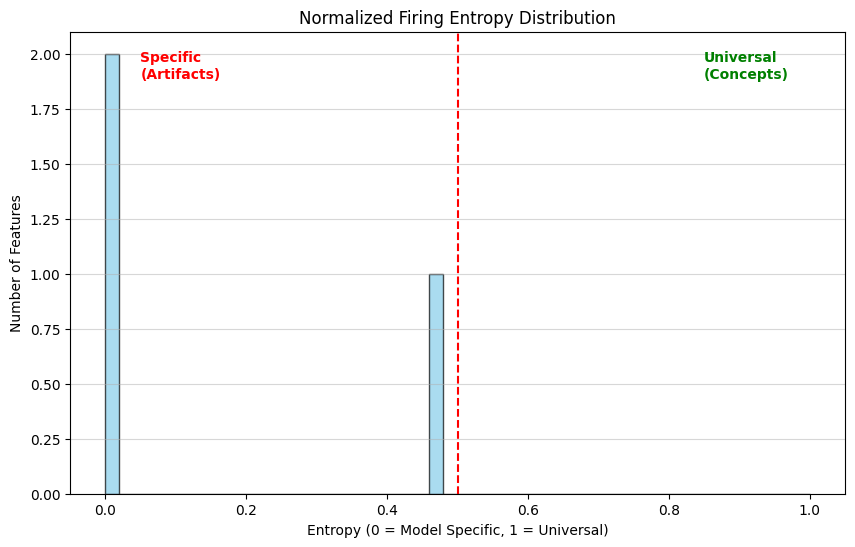

In [63]:
import numpy as np
import matplotlib.pyplot as plt
global_sum_res = torch.zeros(z, device=device)
global_sum_mob = torch.zeros(z, device=device)

for x,_ in test_dataloader:
    xd = x.to(device)
    with torch.no_grad():
        _ = mobile(xd)
        _ = resnet(xd)

        batch_res = sae_res.encode(features["resnet"])[1]
        batch_mobile = sae_mobile.encode(features["mobile"])[1]
        batch_res = batch_res.sum(dim = 0)
        batch_mobile = batch_mobile.sum(dim = 0)
        global_sum_res += batch_res
        global_sum_mob += batch_mobile


print(global_sum_mob.sum().item())
total_a = global_sum_mob + global_sum_res
dead = (total_a <= (100*total_a.mean().item()))
safe_t = total_a.clone()
safe_t[dead] = 1.0

p_res = global_sum_res/safe_t
p_mob = global_sum_mob/safe_t

eps = 1e-9
term_res = p_res * torch.log(p_res + eps)
term_mob = p_mob * torch.log(p_mob + eps)
entropy = -(term_res + term_mob)
extra_normalized_entropy = entropy / np.log(2)
extra_normalized_entropy[dead] = 0.0
entropy_cpu = extra_normalized_entropy.cpu().numpy()
extra_active_entropy = entropy_cpu[~dead.cpu().numpy()]
plt.figure(figsize=(10, 6))
plt.hist(extra_active_entropy, bins=50, range=(0, 1), color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Normalized Firing Entropy Distribution")
plt.xlabel("Entropy (0 = Model Specific, 1 = Universal)")
plt.ylabel("Number of Features")
plt.axvline(x=0.5, color='red', linestyle='--')
plt.grid(axis='y', alpha=0.5)

# Interpretation Text
plt.text(0.05, plt.ylim()[1]*0.9, "Specific\n(Artifacts)", color='red', fontweight='bold')
plt.text(0.85, plt.ylim()[1]*0.9, "Universal\n(Concepts)", color='green', fontweight='bold')

plt.show()

In [22]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Flatten here, but NO normalization, NO detach
        activations[name] = output.flatten(1) 
    return hook

# Reset hooks
if hasattr(resnet, 'avgpool'): resnet.avgpool._forward_hooks.clear()
if hasattr(mobile.classifier, '2'): mobile.classifier[2]._forward_hooks.clear()

resnet.avgpool.register_forward_hook(get_activation('resnet'))
mobile.classifier[2].register_forward_hook(get_activation('mobile'))

In [27]:
import torch.nn.functional as F

def tensor_to_img(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(t.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(t.device)
    t = t * std + mean
    t = t.clamp(0, 1)
    img = t.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    return img

def random_jitter(img, pixels=8):
    ox, oy = np.random.randint(-pixels, pixels+1, 2)
    return torch.roll(img, shifts=(ox, oy), dims=(2, 3))

def maximize_feature(model_name, feature_idx, steps=500, lr=0.05):
    img = torch.randn(1, 3, 224, 224, device=device) * 0.1
    img.requires_grad_(True)
    optimizer = torch.optim.Adam([img], lr=lr, weight_decay=1e-4) 
    
    print(f"  > Starting Opt for {model_name} feature {feature_idx}...")
    
    for i in range(steps):
        jittered_img = random_jitter(img, pixels=8)
        
        if model_name == "resnet":
            _ = resnet(jittered_img)
            raw_feat = activations['resnet']
            norm_feat = F.normalize(raw_feat, p=2, dim=1)
            dense_score = sae_res.encode(norm_feat)[0]
            
        elif model_name == "mobile":
            _ = mobile(jittered_img)
            raw_feat = activations['mobile']
            norm_feat = F.normalize(raw_feat, p=2, dim=1)
            dense_score = sae_mobile.encode(norm_feat)[0]

            
        loss = -dense_score[0, feature_idx]
        
        optimizer.zero_grad()
        loss.backward()
        
        img.grad = img.grad / (torch.norm(img.grad) + 1e-8)
        
        optimizer.step()
        
    return img

In [ ]:
import torch
import torch.nn.functional as F

# Setup
mobile.eval()
resnet.eval()
usae.eval()

print("Collecting activations from FULL Test Set...")

all_z_res = []
all_z_mob = []

# 1. Collect Data (Run on WHOLE loader, do not break early)
for i, (x, _) in enumerate(test_dataloader):
    xd = x.to(device)
    with torch.no_grad():
        _ = mobile(xd)
        _ = resnet(xd)
        
        # Normalize Input
        #print(xd.shape)
        f_res = F.normalize(activations["resnet"], p=2, dim=1)
        f_mob = F.normalize(activations["mobile"], p=2, dim=1)
        #print(f_res.shape)
        #print(features["resnet"].shape)
        # Get SPARSE codes [1]
        z_res = usae.sae_res.encode(f_res)[1]
        z_mob = usae.sae_mobile.encode(f_mob)[1]
        #print(z_res.shape)
        all_z_res.append(z_res.cpu())
        all_z_mob.append(z_mob.cpu())

#print(len(all_z_res))
stack_res = torch.cat(all_z_res, dim=0)
stack_mob = torch.cat(all_z_mob, dim=0)

print(f"Collected data shape: {stack_res.shape}") 
# Should be [10000, 10000] for CIFAR-100 test set

# --- 2. Filter "Dead" or "Rare" Features ---
# A feature must fire on at least 10 images in BOTH models to be analyzed
fires_res = (stack_res > 0).sum(dim=0)
fires_mob = (stack_mob > 0).sum(dim=0)

# Create a mask for "Common" features
valid_mask = (fires_res > 10) & (fires_mob > 10)
valid_indices = torch.nonzero(valid_mask).squeeze()

print(f"Features valid for correlation analysis: {len(valid_indices)}")

if len(valid_indices) == 0:
    print("ERROR: No overlapping features found! Your models might not be aligned yet.")
else:
    # --- 3. Calculate Correlation on Valid Features Only ---
    # Slice the data to save memory/compute
    valid_res = stack_res[:, valid_indices]
    valid_mob = stack_mob[:, valid_indices]

    # Centering
    mean_res = valid_res.mean(dim=0)
    mean_mob = valid_mob.mean(dim=0)
    
    centered_res = valid_res - mean_res
    centered_mob = valid_mob - mean_mob

    # Correlation Formula
    covariance = (centered_res * centered_mob).sum(dim=0)
    var_res = (centered_res ** 2).sum(dim=0)
    var_mob = (centered_mob ** 2).sum(dim=0)

    # Calculate
    correlation = covariance / (torch.sqrt(var_res) * torch.sqrt(var_mob) + 1e-8)

    # --- 4. Select Best ---
    top_vals, top_inds_local = torch.topk(correlation, k=5)
    
    # Map back to global indices
    global_top_inds = valid_indices[top_inds_local]

    print("\n--- TOP CORRELATED FEATURES ---")
    for i in range(len(top_vals)):
        idx = global_top_inds[i].item()
        corr = top_vals[i].item()
        print(f"Feature {idx}: Correlation = {corr:.4f}")
        
    # Update selected_indices for the visualization script
    selected_indices = global_top_inds.tolist()

Collected data shape: torch.Size([10000, 10000])
Features valid for correlation analysis: 81

--- TOP CORRELATED FEATURES ---
Feature 942: Correlation = 0.9356
Feature 7683: Correlation = 0.9268
Feature 5337: Correlation = 0.9187
Feature 5732: Correlation = 0.9116
Feature 3712: Correlation = 0.9114


Visualizing Features: [481, 3551, 3868]
Optimizing Feature 481...
  > Starting Opt for resnet feature 481...
  > Starting Opt for mobile feature 481...
Optimizing Feature 3551...
  > Starting Opt for resnet feature 3551...
  > Starting Opt for mobile feature 3551...
Optimizing Feature 3868...
  > Starting Opt for resnet feature 3868...
  > Starting Opt for mobile feature 3868...


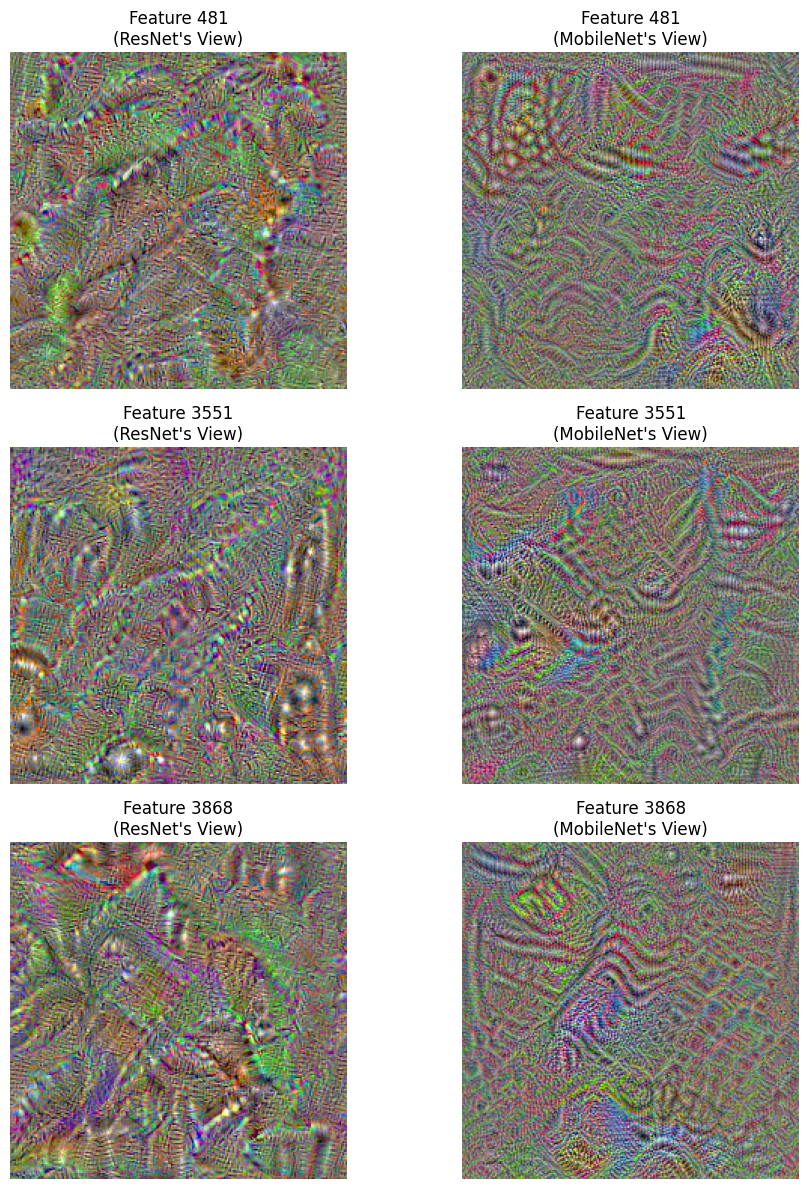

In [28]:
high_entropy_indices = torch.nonzero(extra_normalized_entropy < 0.1).squeeze()
if len(high_entropy_indices.shape) == 0:
    selected_indices = [high_entropy_indices.item()]
else:
    perm = torch.randperm(high_entropy_indices.size(0))
    selected_indices = high_entropy_indices[perm[:3]].tolist()

print(f"Visualizing Features: {selected_indices}")
plt.figure(figsize=(10, 12))

for row_idx, k in enumerate(selected_indices):
    print(f"Optimizing Feature {k}...")
    img_res_tensor = maximize_feature("resnet", k)
    img_res = tensor_to_img(img_res_tensor)
    img_mob_tensor = maximize_feature("mobile", k)
    img_mob = tensor_to_img(img_mob_tensor)
    plt.subplot(len(selected_indices), 2, row_idx*2 + 1)
    plt.imshow(img_res)
    plt.title(f"Feature {k}\n(ResNet's View)")
    plt.axis('off')
    plt.subplot(len(selected_indices), 2, row_idx*2 + 2)
    plt.imshow(img_mob)
    plt.title(f"Feature {k}\n(MobileNet's View)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn.functional as F

def tensor_to_img(t):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(t.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(t.device)
    t = t * std + mean
    t = t.clamp(0, 1)
    img = t.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    return img

def random_jitter(img, pixels=8):
    ox, oy = np.random.randint(-pixels, pixels+1, 2)
    return torch.roll(img, shifts=(ox, oy), dims=(2, 3))

def maximize_feature(model_name, feature_idx, steps=500, lr=0.05,img = None):
    if img == None:
        img = torch.randn(1, 3, 224, 224, device=device) * 0.1
    img.requires_grad_(True)
    optimizer = torch.optim.Adam([img], lr=lr, weight_decay=1e-4) 
    
    print(f"  > Starting Opt for {model_name} feature {feature_idx}...")
    
    for i in range(steps):
        jittered_img = random_jitter(img, pixels=8)
        
        if model_name == "resnet":
            _ = resnet(jittered_img)
            raw_feat = activations['resnet']
            norm_feat = F.normalize(raw_feat, p=2, dim=1)
            dense_score = usae.sae_res.encode(norm_feat)[0]
            
        elif model_name == "mobile":
            _ = mobile(jittered_img)
            raw_feat = activations['mobile']
            norm_feat = F.normalize(raw_feat, p=2, dim=1)
            dense_score = usae.sae_mobile.encode(norm_feat)[0]

            
        loss = -dense_score[0, feature_idx]
        
        optimizer.zero_grad()
        loss.backward()
        
        img.grad = img.grad / (torch.norm(img.grad) + 1e-8)
        
        optimizer.step()
        
    return img

Visualizing Features: [366, 7210, 9287]
Optimizing Feature 366...
  > Starting Opt for resnet feature 366...
  > Starting Opt for mobile feature 366...
Optimizing Feature 7210...
  > Starting Opt for resnet feature 7210...
  > Starting Opt for mobile feature 7210...
Optimizing Feature 9287...
  > Starting Opt for resnet feature 9287...
  > Starting Opt for mobile feature 9287...


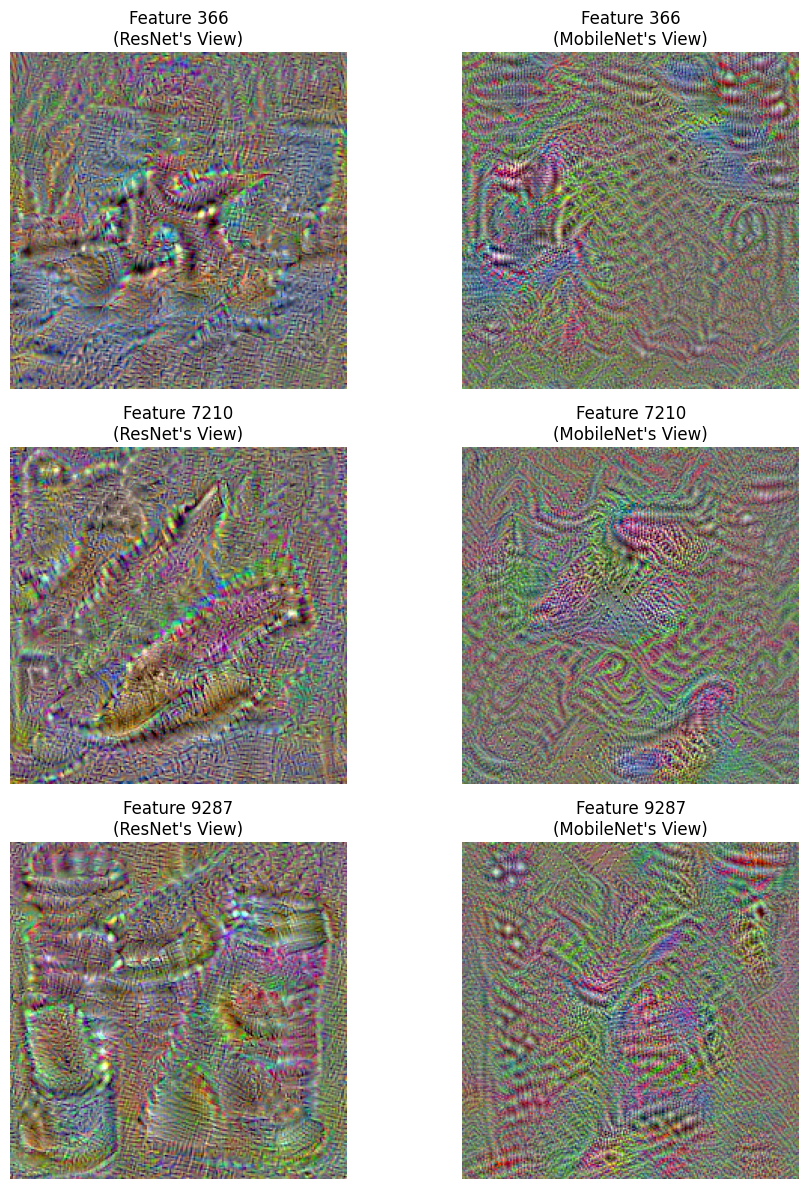

In [54]:
high_entropy_indices = torch.nonzero(normalized_entropy > 0.9).squeeze()
if len(high_entropy_indices.shape) == 0:
    selected_indices = [high_entropy_indices.item()]
else:
    perm = torch.randperm(high_entropy_indices.size(0))
    selected_indices = high_entropy_indices[perm[:3]].tolist()

print(f"Visualizing Features: {selected_indices}")
plt.figure(figsize=(10, 12))

for row_idx, k in enumerate(selected_indices):
    print(f"Optimizing Feature {k}...")
    img_res_tensor = maximize_feature("resnet", k)
    img_res = tensor_to_img(img_res_tensor)
    img_mob_tensor = maximize_feature("mobile", k)
    img_mob = tensor_to_img(img_mob_tensor)
    plt.subplot(len(selected_indices), 2, row_idx*2 + 1)
    plt.imshow(img_res)
    plt.title(f"Feature {k}\n(ResNet's View)")
    plt.axis('off')
    plt.subplot(len(selected_indices), 2, row_idx*2 + 2)
    plt.imshow(img_mob)
    plt.title(f"Feature {k}\n(MobileNet's View)")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [32]:
def find(rsae, msae, data_loader, indicis):
    scores_res = [float('-inf')] * len(indicis)
    scores_mob = [float('-inf')] * len(indicis)
    img_res = [None] * len(indicis)
    img_mob = [None] * len(indicis)

    for x, _ in data_loader:
        xd = x.to(device)
        with torch.no_grad():
            # forward pass
            _ = mobile(xd)
            _ = resnet(xd)

            # normalize activations
            f_res = F.normalize(activations["resnet"], p=2, dim=1)
            f_mob = F.normalize(activations["mobile"], p=2, dim=1)

            # encode into SAE latent space
            r_latent = rsae.encode(f_res)[1]  # batch x latent_dim
            m_latent = msae.encode(f_mob)[1]  # batch x latent_dim

            # iterate over the latent indices of interest
            for idx_pos, idx in enumerate(indicis):
                # RSAE
                batch_max_r, batch_max_idx_r = r_latent[:, idx].max(0)
                if batch_max_r.item() >= scores_res[idx_pos]:
                    scores_res[idx_pos] = batch_max_r.item()
                    img_res[idx_pos] = x[batch_max_idx_r].cpu()  # store input image

                # MSAE
                batch_max_m, batch_max_idx_m = m_latent[:, idx].max(0)
                if batch_max_m.item() >= scores_mob[idx_pos]:
                    scores_mob[idx_pos] = batch_max_m.item()
                    img_mob[idx_pos] = x[batch_max_idx_m].cpu()  # store input image

    return img_res, img_mob


    

In [ ]:
def find_top3(rsae, msae, data_loader, indicis):
    import torch

    # Initialize lists for top-3 scores and images
    topk = 3
    scores_res = [[float('-inf')] * topk for _ in indicis]
    scores_mob = [[float('-inf')] * topk for _ in indicis]
    img_res = [[None] * topk for _ in indicis]
    img_mob = [[None] * topk for _ in indicis]

    for x, _ in data_loader:
        xd = x.to(device)
        with torch.no_grad():
            # forward pass
            _ = mobile(xd)
            _ = resnet(xd)

            # normalize activations
            f_res = F.normalize(activations["resnet"], p=2, dim=1)
            f_mob = F.normalize(activations["mobile"], p=2, dim=1)

            # encode into SAE latent space
            r_latent = rsae.encode(f_res)[1]  # batch x latent_dim
            m_latent = msae.encode(f_mob)[1]  # batch x latent_dim

            # iterate over latent indices
            for idx_pos, idx in enumerate(indicis):
                # RSAE
                batch_vals_r, batch_idx_r = r_latent[:, idx].topk(topk, largest=True)
                for k in range(topk):
                    if batch_vals_r[k].item() > scores_res[idx_pos][k]:
                        scores_res[idx_pos][k] = batch_vals_r[k].item()
                        img_res[idx_pos][k] = x[batch_idx_r[k]].cpu()

                # MSAE
                batch_vals_m, batch_idx_m = m_latent[:, idx].topk(topk, largest=True)
                for k in range(topk):
                    if batch_vals_m[k].item() > scores_mob[idx_pos][k]:
                        scores_mob[idx_pos][k] = batch_vals_m[k].item()
                        img_mob[idx_pos][k] = x[batch_idx_m[k]].cpu()

    return img_res, img_mob


Optimizing Feature 5773...
Optimizing Feature 4123...
Optimizing Feature 1752...


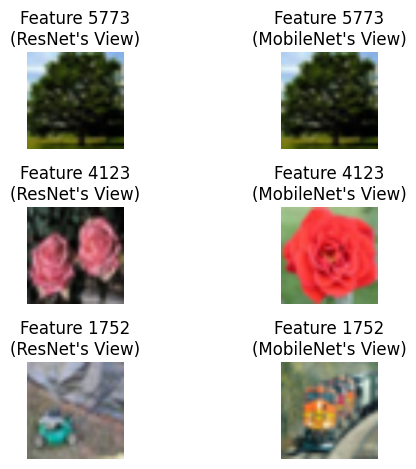

In [ ]:
high_entropy_indices = torch.nonzero(normalized_entropy > 0.9).squeeze()
if len(high_entropy_indices.shape) == 0:
    selected_indices = [high_entropy_indices.item()]
else:
    perm = torch.randperm(high_entropy_indices.size(0))
    selected_indices = high_entropy_indices[perm[:3]].tolist()

print(f"Visualizing Features: {selected_indices}")
plt.figure(figsize=(10, 12))


img_ress,img_mobs = find(usae.sae_res,usae.sae_mobile,train_loader, selected_indices)

for row_idx, k in enumerate(selected_indices):
    print(f"Optimizing Feature {k}...")
    img_res = tensor_to_img(img_ress[row_idx])
    img_mob = tensor_to_img(img_mobs[row_idx])
    plt.subplot(len(selected_indices), 2, row_idx*2 + 1)
    plt.imshow(img_res)
    plt.title(f"Feature {k}\n(ResNet's View)")
    plt.axis('off')
    plt.subplot(len(selected_indices), 2, row_idx*2 + 2)
    plt.imshow(img_mob)
    plt.title(f"Feature {k}\n(MobileNet's View)")
    plt.axis('off')

plt.tight_layout()
plt.show()

Visualizing Features: [2095, 2014, 7339]


<Figure size 1200x1200 with 0 Axes>

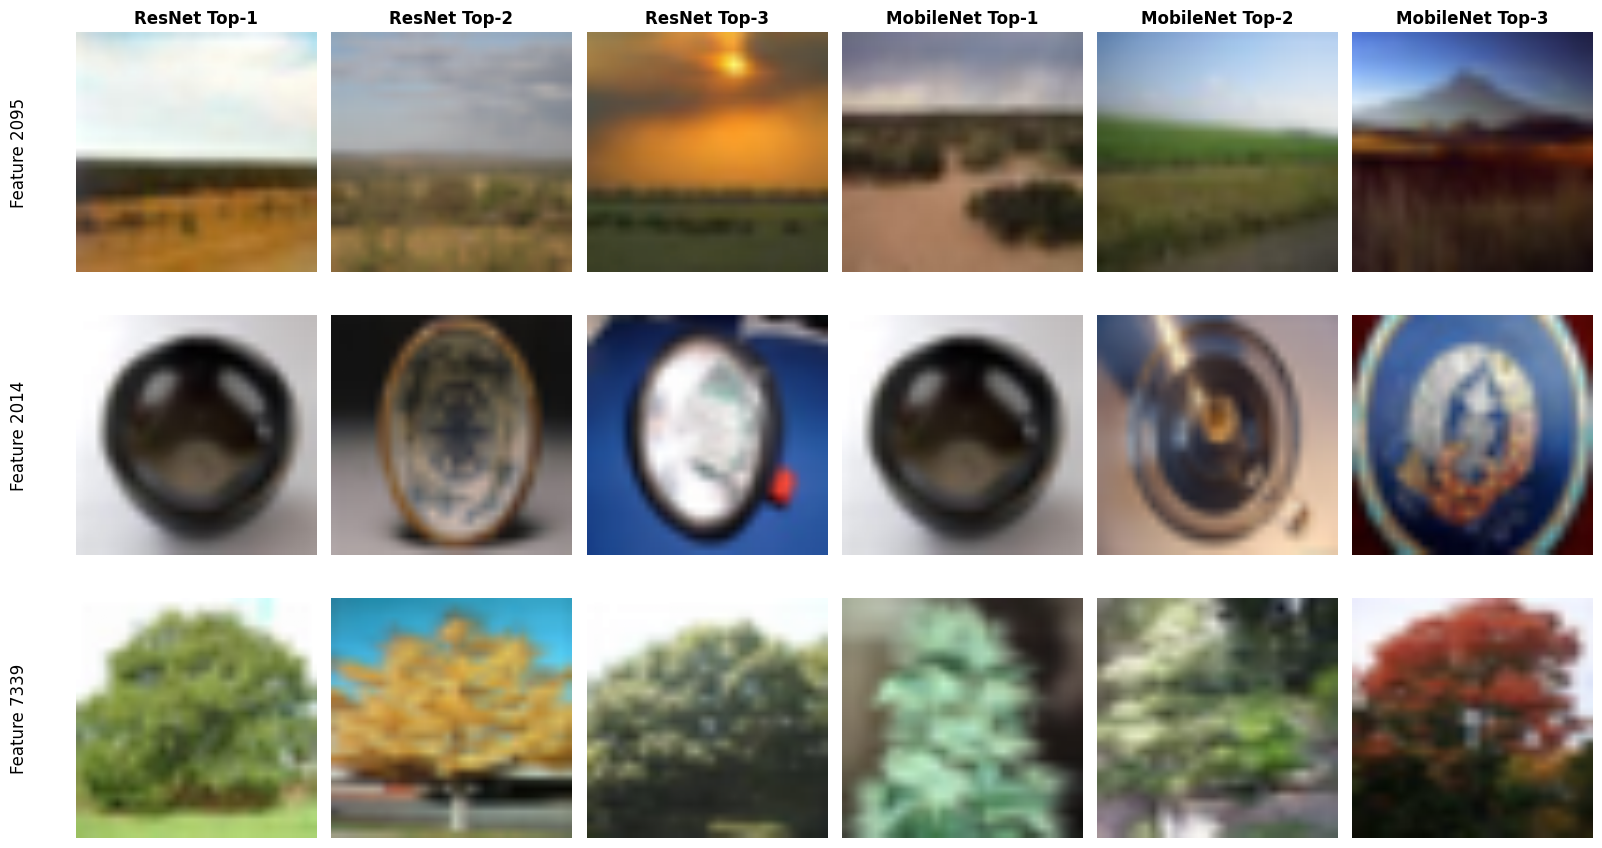

In [53]:
high_entropy_indices = torch.nonzero(normalized_entropy > 0.9).squeeze()
if len(high_entropy_indices.shape) == 0:
    selected_indices = [high_entropy_indices.item()]
else:
    perm = torch.randperm(high_entropy_indices.size(0))
    selected_indices = high_entropy_indices[perm[:3]].tolist()

print(f"Visualizing Features: {selected_indices}")
plt.figure(figsize=(12, 12))

# Use the modified find function that returns top-3 images
img_ress, img_mobs= find_top3(usae.sae_res, usae.sae_mobile, train_loader, selected_indices)

import matplotlib.pyplot as plt

# Define grid dimensions
rows = len(selected_indices)
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))

# Column headers (only displayed on the first row)
col_headers = [
    "ResNet Top-1", "ResNet Top-2", "ResNet Top-3",
    "MobileNet Top-1", "MobileNet Top-2", "MobileNet Top-3"
]

for row_idx, k in enumerate(selected_indices):
    # --- Plot ResNet Images (Columns 0-2) ---
    for i in range(3):
        ax = axes[row_idx, i]
        img = tensor_to_img(img_ress[row_idx][i])
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i], fontsize=12, fontweight='bold')
            
        # Add Row Label to the very first image of the row
        if i == 0:
            ax.text(-0.2, 0.5, f"Feature {k}", transform=ax.transAxes, 
                    va='center', ha='right', fontsize=12, rotation=90)

    # --- Plot MobileNet Images (Columns 3-5) ---
    for i in range(3):
        ax = axes[row_idx, i + 3] # Offset by 3 for the second half
        img = tensor_to_img(img_mobs[row_idx][i])
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i + 3], fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
high_entropy_indices = torch.nonzero(normalized_entropy > 0.9).squeeze()
if len(high_entropy_indices.shape) == 0:
    selected_indices = [high_entropy_indices.item()]
else:
    perm = torch.randperm(high_entropy_indices.size(0))
    selected_indices = high_entropy_indices[perm[:3]].tolist()

print(f"Visualizing Features: {selected_indices}")
plt.figure(figsize=(12, 12))

# Use the modified find function that returns top-3 images
img_ress, img_mobs= find_top3(usae.sae_res, usae.sae_mobile, train_loader, selected_indices)

import matplotlib.pyplot as plt

# Define grid dimensions
rows = len(selected_indices)
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))

# Column headers (only displayed on the first row)
col_headers = [
    "ResNet Top-1", "ResNet Top-2", "ResNet Top-3",
    "MobileNet Top-1", "MobileNet Top-2", "MobileNet Top-3"
]

for row_idx, k in enumerate(selected_indices):
    # --- Plot ResNet Images (Columns 0-2) ---
    for i in range(3):
        ax = axes[row_idx, i]
        img_res_tensor = maximize_feature("resnet", k,img_ress[row_idx][[i]])
        img = tensor_to_img(img_res_tensor)
        # img_mob_tensor = maximize_feature("mobile", k)
        # img_mob = tensor_to_img(img_mob_tensor)
        # img = tensor_to_img(img_ress[row_idx][i])
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i], fontsize=12, fontweight='bold')
            
        # Add Row Label to the very first image of the row
        if i == 0:
            ax.text(-0.2, 0.5, f"Feature {k}", transform=ax.transAxes, 
                    va='center', ha='right', fontsize=12, rotation=90)

    # --- Plot MobileNet Images (Columns 3-5) ---
    for i in range(3):
        ax = axes[row_idx, i + 3] # Offset by 3 for the second half
        img_mob_tensor = maximize_feature("mobile", k,img_mobs[row_idx][[i]])
        img = tensor_to_img(img_mob_tensor)
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i + 3], fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


Visualizing Features: [2500, 4123, 6615]


Visualizing Features: [4846, 9452]


<Figure size 1200x1200 with 0 Axes>

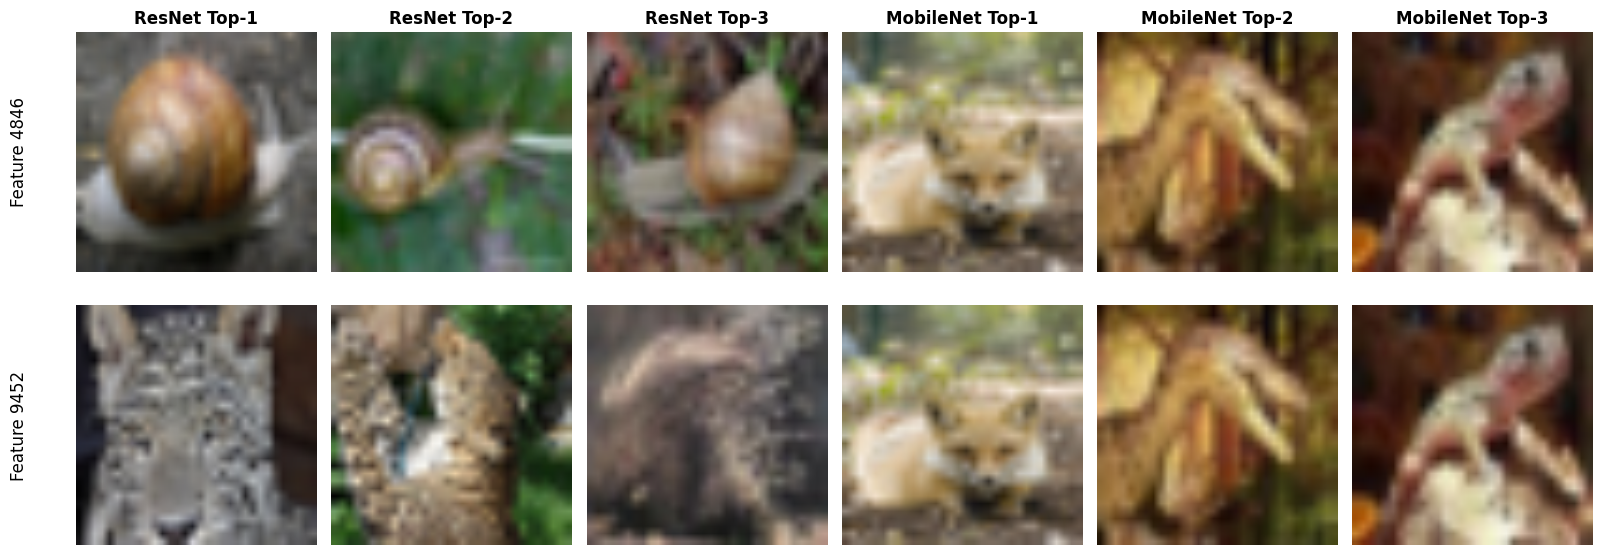

In [65]:
mask = (extra_normalized_entropy < 0.1) & (~dead)
high_entropy_indices = torch.nonzero(mask).squeeze()
if len(high_entropy_indices.shape) == 0:
    selected_indices = [high_entropy_indices.item()]
else:
    perm = torch.randperm(high_entropy_indices.size(0))
    selected_indices = high_entropy_indices[perm[:3]].tolist()

print(f"Visualizing Features: {selected_indices}")
plt.figure(figsize=(12, 12))


img_ress, img_mobs= find_top3(sae_res, sae_mobile, train_loader, selected_indices)



import matplotlib.pyplot as plt

# Define grid dimensions
rows = len(selected_indices)
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))

# Column headers (only displayed on the first row)
col_headers = [
    "ResNet Top-1", "ResNet Top-2", "ResNet Top-3",
    "MobileNet Top-1", "MobileNet Top-2", "MobileNet Top-3"
]

for row_idx, k in enumerate(selected_indices):
    # --- Plot ResNet Images (Columns 0-2) ---
    for i in range(3):
        ax = axes[row_idx, i]
        img = tensor_to_img(img_ress[row_idx][i])
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i], fontsize=12, fontweight='bold')
            
        # Add Row Label to the very first image of the row
        if i == 0:
            ax.text(-0.2, 0.5, f"Feature {k}", transform=ax.transAxes, 
                    va='center', ha='right', fontsize=12, rotation=90)

    # --- Plot MobileNet Images (Columns 3-5) ---
    for i in range(3):
        ax = axes[row_idx, i + 3] # Offset by 3 for the second half
        img = tensor_to_img(img_mobs[row_idx][i])
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i + 3], fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Visualizing Features: [7721, 9385, 3951]
0
0
0
1
1
1
2
2
2


<Figure size 1200x1200 with 0 Axes>

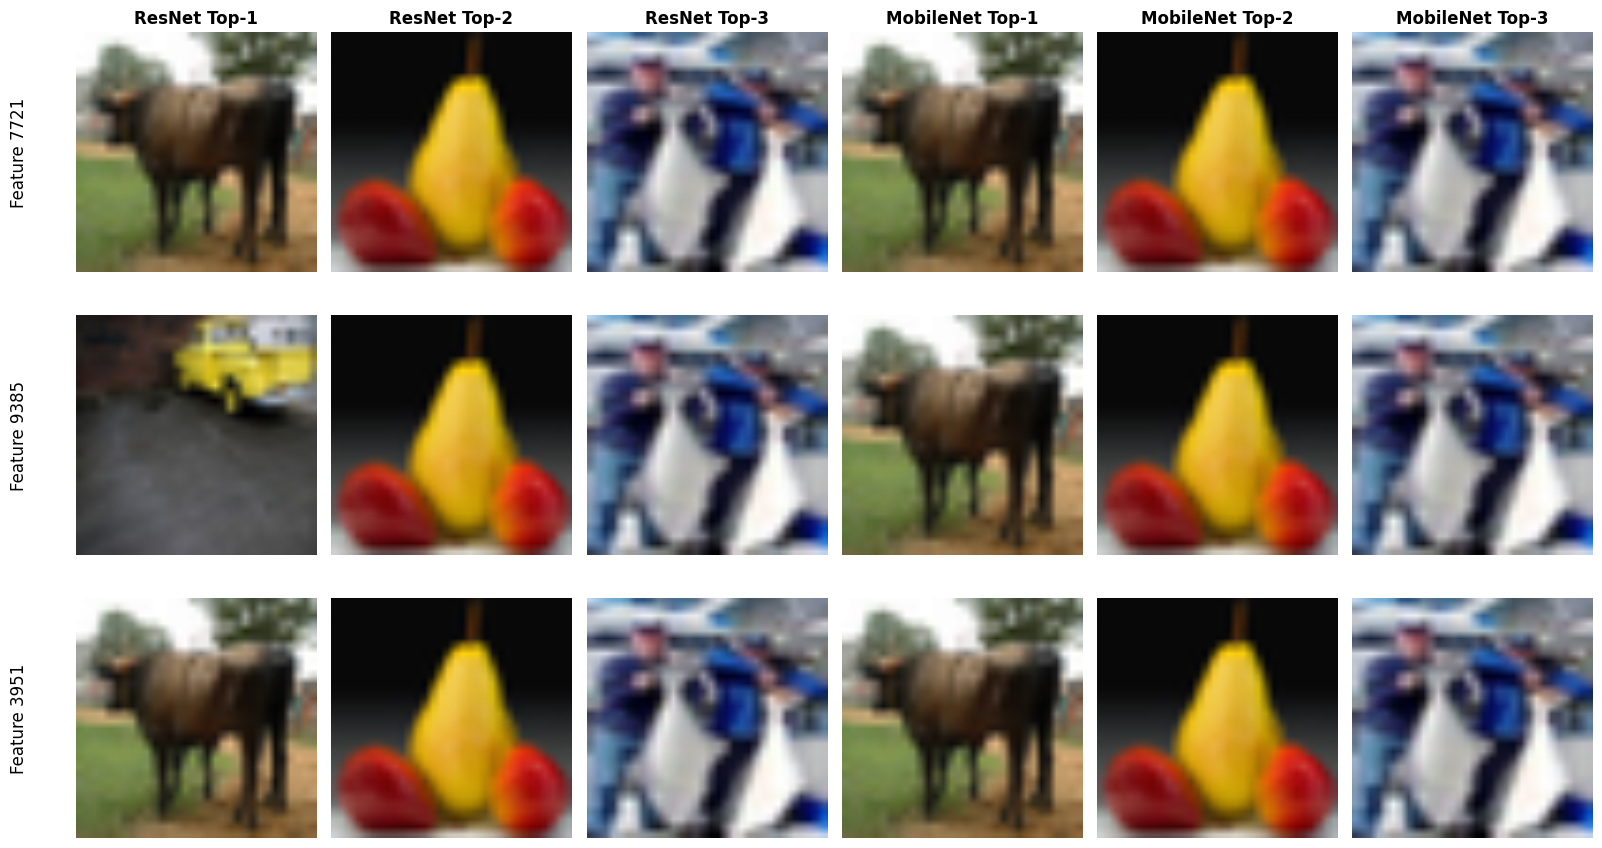

In [66]:
high_entropy_indices = torch.nonzero(normalized_entropy < 0.1).squeeze()
if len(high_entropy_indices.shape) == 0:
    selected_indices = [high_entropy_indices.item()]
else:
    perm = torch.randperm(high_entropy_indices.size(0))
    selected_indices = high_entropy_indices[perm[:3]].tolist()

print(f"Visualizing Features: {selected_indices}")
plt.figure(figsize=(12, 12))

# Use the modified find function that returns top-3 images
img_ress, img_mobs= find_top3(usae.sae_res, usae.sae_mobile, train_loader, selected_indices)

import matplotlib.pyplot as plt

# Define grid dimensions
rows = len(selected_indices)
cols = 6
fig, axes = plt.subplots(rows, cols, figsize=(16, 3 * rows))

# Column headers (only displayed on the first row)
col_headers = [
    "ResNet Top-1", "ResNet Top-2", "ResNet Top-3",
    "MobileNet Top-1", "MobileNet Top-2", "MobileNet Top-3"
]

for row_idx, k in enumerate(selected_indices):
    # --- Plot ResNet Images (Columns 0-2) ---
    for i in range(3):
        ax = axes[row_idx, i]
        print(row_idx)
        img = tensor_to_img(img_ress[row_idx][i])
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i], fontsize=12, fontweight='bold')
            
        # Add Row Label to the very first image of the row
        if i == 0:
            ax.text(-0.2, 0.5, f"Feature {k}", transform=ax.transAxes, 
                    va='center', ha='right', fontsize=12, rotation=90)

    # --- Plot MobileNet Images (Columns 3-5) ---
    for i in range(3):
        ax = axes[row_idx, i + 3] # Offset by 3 for the second half
        img = tensor_to_img(img_mobs[row_idx][i])
        ax.imshow(img)
        ax.axis('off')
        
        # Add column titles only to the first row
        if row_idx == 0:
            ax.set_title(col_headers[i + 3], fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
